In [1]:
from scripts import bookdatafunctions as bdf
from scripts import corpusMLfunctions as cmf
import pandas as pd
import seaborn as sns
import matplotlib
import warnings
from tqdm import tqdm
from scipy.stats import bootstrap
from resample.bootstrap import resample
import numpy as np
from pprint import pprint
from time import perf_counter
warnings.filterwarnings('ignore')
import multiprocessing as mp

/home/tenojo/miniconda3/envs/Test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Constants

#Number of rounds to bootstrap
RUNS = 1000

#Meaningful effect size for Cohen's d
MES = 0.79

#In how big a proportion do feats need to appear in to be considered consistant

CONSISTANT = 0.90

ISBN2AGE_PATH = "ISBN_MAPS/ISBN2AGE.xlsx"

In [3]:
#Nab corpus and transform ages
corpus = bdf.mapGroup2Age(bdf.initBooksFromConllus("Conllus"), ISBN2AGE_PATH)

In [4]:
#Define sub-corpora
"""
ages = sorted(bdf.getAvailableAges(corpus))
#Generate correct keys/ids
group_1 = [5,6,7,8]
group_2 = [9,10,11,12]
group_3 = [a for a in ages if a>12]
#Distinct subcorpora
sub_corp_1= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_1])
sub_corp_2= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_2])
sub_corp_3= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_3])
sub_corps = dict(zip(['7-8','9-12','13+'],[sub_corp_1, sub_corp_2, sub_corp_3]))
"""

"\nages = sorted(bdf.getAvailableAges(corpus))\n#Generate correct keys/ids\ngroup_1 = [5,6,7,8]\ngroup_2 = [9,10,11,12]\ngroup_3 = [a for a in ages if a>12]\n#Distinct subcorpora\nsub_corp_1= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_1])\nsub_corp_2= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_2])\nsub_corp_3= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_3])\nsub_corps = dict(zip(['7-8','9-12','13+'],[sub_corp_1, sub_corp_2, sub_corp_3]))\n"

In [5]:
#Prep feature amounts etc. to hopefully speed up calculations
#Old, non-parallelized version
"""
#Data structure will be dict[num,dict[id,dict[feat,value]]]
sub_corps_values = {'7-8':{}, '9-12':{}, '13+':{}}
index_dict = {}
for sub_corp in sub_corps:
    sub_corp_values = {}
    for book in sub_corps[sub_corp]:
        #If first book, then initialize index_dict that maps indices to features
        if len(index_dict) == 0:
            feat_vector, index_dict = cmf.customConlluVectorizer(sub_corps[sub_corp][book], True)
        #If index_dict already exists, then just fill out the feature vector
        else:
            feat_vector = cmf.customConlluVectorizer(sub_corps[sub_corp][book])
        #Generate a dictionary that has feature names as keys and feature values as values
        book_values = {index_dict[x]:feat_vector[x] for x in index_dict}
        #Save to sub_corp's dict
        sub_corp_values[book] = book_values
        #Save to sub_corps' dict
    sub_corps_values[sub_corp] = sub_corp_values
"""

"\n#Data structure will be dict[num,dict[id,dict[feat,value]]]\nsub_corps_values = {'7-8':{}, '9-12':{}, '13+':{}}\nindex_dict = {}\nfor sub_corp in sub_corps:\n    sub_corp_values = {}\n    for book in sub_corps[sub_corp]:\n        #If first book, then initialize index_dict that maps indices to features\n        if len(index_dict) == 0:\n            feat_vector, index_dict = cmf.customConlluVectorizer(sub_corps[sub_corp][book], True)\n        #If index_dict already exists, then just fill out the feature vector\n        else:\n            feat_vector = cmf.customConlluVectorizer(sub_corps[sub_corp][book])\n        #Generate a dictionary that has feature names as keys and feature values as values\n        book_values = {index_dict[x]:feat_vector[x] for x in index_dict}\n        #Save to sub_corp's dict\n        sub_corp_values[book] = book_values\n        #Save to sub_corps' dict\n    sub_corps_values[sub_corp] = sub_corp_values\n"

In [6]:
def processBookAndAddToDict(passed_data):
    book_id, book_data = passed_data
    feat_vector = cmf.customConlluVectorizer(book_data)
    return (book_id, feat_vector)

In [7]:
#List of items so that we can use map_async
corpus_items = list(corpus.items())

#Generate index dict
temp, index_dict = cmf.customConlluVectorizer(list(corpus.values())[0], True)



results = []
#Use multiprocessing to speed up vectorizing all books
with mp.Pool(mp.cpu_count()) as pool:
    with tqdm(total=len(corpus)) as pbar:
        def update(a):
            pbar.update()
        async_results = [pool.apply_async(processBookAndAddToDict, args=(item,), callback=update) for item in corpus_items]
        results = [async_result.get() for async_result in async_results]

100%|██████████| 300/300 [08:41<00:00,  1.74s/it]


## Code for checking correlations between variables

In [8]:
feat_dict = {index_dict[i]: i for i in index_dict}

In [9]:
print(feat_dict['ccomp'])

17


In [10]:
all_values = np.array([x[1] for x in results])

corr_coefs = np.nan_to_num(np.corrcoef(all_values, rowvar=False))

In [11]:
strongly_correlating = np.argwhere(corr_coefs[17]>0.9)
strongly_correlating = [index_dict[x[0]] for x in strongly_correlating]
print(strongly_correlating)

['mark', 'ccomp', 'SCONJ', 'root_ccomp', 'ccomp_advmod', 'ccomp_obl', 'ccomp_obj', 'ccomp_aux', 'ccomp_mark', 'ccomp_cop', 'ccomp_nsubj:cop', 'ccomp_advcl']


<Axes: >

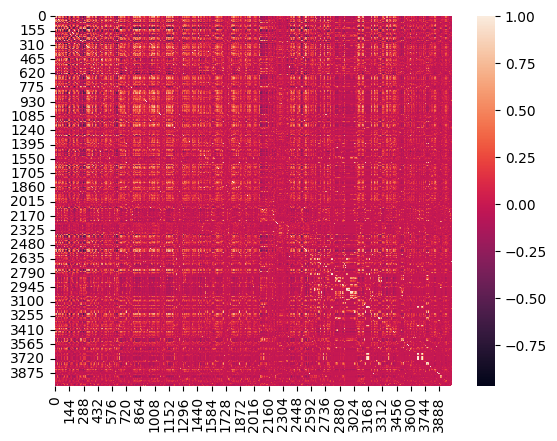

In [12]:
sns.heatmap(corr_coefs)

## Code for KFA

In [13]:
#Transforming list of items to dicts usable by the code below this block

#Number of bootstrap runs
RUNS = 1000


#Defining subcorpora
ages = sorted(bdf.getAvailableAges(corpus))
#Generate correct keys/ids
group_1 = [5,6,7,8]
group_2 = [9,10,11,12]
group_3 = [a for a in ages if a>12]
#Distinct subcorpora
sub_corp_1= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_1])
sub_corp_2= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_2])
sub_corp_3= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_3])
sub_corps = dict(zip(['7-8','9-12','13+'],[sub_corp_1, sub_corp_2, sub_corp_3]))

#Values to a dictionary

sub_corps_values = {'7-8':{}, '9-12':{}, '13+':{}}

for id, data in results:
    age = int(bdf.findAgeFromID(id))
    if age < 9:
        sub_corps_values['7-8'][id] = {index_dict[x]:data[x] for x in index_dict}
    elif age < 13:
        sub_corps_values['9-12'][id] = {index_dict[x]:data[x] for x in index_dict}
    else:
        sub_corps_values['13+'][id] = {index_dict[x]:data[x] for x in index_dict}

In [14]:
#Using resample's bootstrapping method to gain lists of keys for each subcorp
bootstrapped_books = {j: [x for x in resample(list(sub_corps[j].keys()), size=RUNS)] for j in sub_corps}

In [15]:
#Some helper functions for this notebook
import math
def cohensdForValues(data1: list[float], data2: list[float]) -> float:
    #Sample size
    n1, n2 = len(data1), len(data2)
    #Variance
    s1, s2 = np.var(data1, ddof=1), np.var(data2, ddof=1)
    #Pooled standard deviation
    s = math.sqrt( ((n1-1)*s1 + (n2-1)*s2)/(n1+n2-2) )
    #Return Cohen's d
    return ((np.mean(data1)-np.mean(data2)) / s)

def valueListFromKeys(values, keys, feat):
    return [values[key][feat] for key in keys]

def sub_columns(columns: list[str], start: str) -> list[str]:
    return [c for c in columns if c[0:len(start)] == start]

In [ ]:
#Old, non-parallelized implementation

effect_sizes_per_run = {}
with tqdm(range(RUNS), desc="Iterating over bootstrapped subcorpora...") as pbar:
    for i in range(RUNS):
        effect_sizes = {}
        for key1 in sub_corps:
            books_1 = bootstrapped_books[key1][i]
            values_1 = sub_corps_values[key1]
            for key2 in sub_corps:
                new_key = str(key1)+" vs. "+str(key2)
                #Skip if we already have the inverse
                if new_key in list(effect_sizes.keys()):
                    continue
                #If keys are the same, then d will be 0 always so save computing time
                if key1 == key2:
                    effect_sizes[new_key] = [0]*len(index_dict)
                    continue
                books_2 = bootstrapped_books[key2][i]
                values_2 = sub_corps_values[key2]
                #Oneliner that calculates Cohen's d for all feats between bootstrapped subcorps
                effect_sizes_temp = np.array([cohensdForValues(valueListFromKeys(values_1, books_1, index_dict[feat]), valueListFromKeys(values_2, books_2, index_dict[feat])) for feat in index_dict])
                effect_sizes[new_key] = effect_sizes_temp
                #Add the inverse to the dict
                new_key = str(key2)+" vs. "+str(key1)
                effect_sizes[new_key] = effect_sizes_temp * -1
        effect_sizes_per_run[i] = effect_sizes
        pbar.update(1)

'\neffect_sizes_per_run = {}\nwith tqdm(range(RUNS), desc="Iterating over bootstrapped subcorpora...") as pbar:\n    for i in range(RUNS):\n        effect_sizes = {}\n        for key1 in sub_corps:\n            books_1 = bootstrapped_books[key1][i]\n            values_1 = sub_corps_values[key1]\n            for key2 in sub_corps:\n                new_key = str(key1)+" vs. "+str(key2)\n                #If keys are the same, then d will be 0 always so save computing time\n                if key1 == key2:\n                    effect_sizes[new_key] = [0]*len(index_dict)\n                    continue\n                books_2 = bootstrapped_books[key2][i]\n                values_2 = sub_corps_values[key2]\n                #Oneliner that calculates Cohen\'s d for all feats between bootstrapped subcorps\n                effect_sizes_temp = [cohensdForValues(valueListFromKeys(values_1, books_1, index_dict[feat]), valueListFromKeys(values_2, books_2, index_dict[feat])) for feat in index_dict]\n 

In [ ]:
"""
def calcEffectSizes(run_number, sub_corps, bootstrapped_books, sub_corps_values, index_dict):
    effect_sizes = {}
    for key1 in sub_corps:
        books_1 = bootstrapped_books[key1][run_number]
        values_1 = sub_corps_values[key1]
        for key2 in sub_corps:
            new_key = str(key1)+" vs. "+str(key2)
            #Skip if we already have the inverse
            if new_key in list(effect_sizes.keys()):
                continue
            #If keys are the same, then d will be 0 always so save computing time
            if key1 == key2:
                effect_sizes[new_key] = [0]*len(index_dict)
                continue
            books_2 = bootstrapped_books[key2][run_number]
            values_2 = sub_corps_values[key2]
            #Oneliner that calculates Cohen's d for all feats between bootstrapped subcorps
            effect_sizes_temp = np.array([cohensdForValues(valueListFromKeys(values_1, books_1, index_dict[feat]), valueListFromKeys(values_2, books_2, index_dict[feat])) for feat in index_dict])
            effect_sizes[new_key] = effect_sizes_temp
            #Add the inverse to the dict
            new_key = str(key2)+" vs. "+str(key1)
            effect_sizes[new_key] = effect_sizes_temp * -1
    return (run_number, effect_sizes)
"""

In [ ]:
#Parallelized version of calculating effect sizes (KFA)
"""
e_s = []
#Use multiprocessing to speed up vectorizing all books
with mp.Pool(mp.cpu_count()-1) as pool:
    with tqdm(total=RUNS) as pbar:
        def update(a):
            pbar.update()
        async_results = [pool.apply_async(calcEffectSizes, args=(i, sub_corps, bootstrapped_books, sub_corps_values, index_dict), callback=update) for i in range(RUNS)]
        e_s = [async_result.get() for async_result in async_results]
#Combine results together
effect_sizes_per_run = {s[0]:s[1] for s in e_s}
"""

  0%|          | 4/1000 [00:25<1:43:27,  6.23s/it]

## Finding consistantly meaningful feats according to Cohen's d values over bootstrapped runs

In [ ]:
#Function for calculating which features are classified as somewhat meaningful for a set of cohen's d values
def meaningfulFeats(meaningful_ef_size, ef_sizes):

    sep_between_two = []
    for corp in ef_sizes:
        y_1 = abs(np.nan_to_num(ef_sizes[corp]))
        for i in index_dict:
            if y_1[i]>=meaningful_ef_size:
                sep_between_two.append(index_dict[i])

    return list(set(sep_between_two))

In [ ]:
meaningful_feats_strong = []
meaningful_feats_medium = []
meaningful_feats_weak = []
with tqdm(range(RUNS), desc="Calculating meaningful effects per run...") as pbar:
    for i in effect_sizes_per_run:
        meaningful_feats_strong.append(meaningfulFeats(0.79, effect_sizes_per_run[i]))
        meaningful_feats_medium.append(meaningfulFeats(0.49, effect_sizes_per_run[i]))
        meaningful_feats_weak.append(meaningfulFeats(0.29, effect_sizes_per_run[i]))
        pbar.update(1)

Calculating meaningful effects per run...: 100%|██████████| 100/100 [00:03<00:00, 30.99it/s]


In [ ]:
from collections import Counter
import itertools

print("Strong ef size: ",Counter(list(itertools.chain.from_iterable(meaningful_feats_strong))))
feat_counts_strong = dict(Counter(list(itertools.chain.from_iterable(meaningful_feats_strong))))
print("Medium ef size: ",Counter(list(itertools.chain.from_iterable(meaningful_feats_medium))))
feat_counts_medium = dict(Counter(list(itertools.chain.from_iterable(meaningful_feats_medium))))
print("Weak ef size: ",Counter(list(itertools.chain.from_iterable(meaningful_feats_weak))))
feat_counts_weak = dict(Counter(list(itertools.chain.from_iterable(meaningful_feats_weak))))

Strong ef size:  Counter({'VERB_AUX_VERB': 98, 'Reflex=Yes': 90, 'AUX_VERB_VERB': 81, 'ccomp': 81, 'Derivation=Ton': 81, 'ADV_To_SCONJ_Ratio': 80, 'SCONJ_To_ADV_Ratio': 78, 'PRON_PUNCT': 75, 'PUNCT_PROPN_CCONJ': 75, 'INTJ_PUNCT_NOUN': 74, 'SCONJ_AUX_VERB': 68, 'Number[psor]=Sing': 65, 'AUX_PRON_PUNCT': 65, 'PUNCT_PRON_INTJ': 64, 'VERB_PRON_PUNCT': 64, 'root_ccomp': 62, 'PROPN_CCONJ_PROPN': 60, 'NOUN_PUNCT_INTJ': 58, 'AUX_AUX': 58, 'SCONJ_AUX_AUX': 54, 'AUX_AUX_VERB': 54, 'TTR': 53, 'ccomp_obj': 52, 'INTJ_To_SCONJ_Ratio': 52, 'Person[psor]=1': 51, 'AUX_VERB_PRON': 51, 'SCONJ_AUX': 50, 'ccomp_xcomp': 49, 'ccomp_cop': 49, 'PRON_INTJ_PRON': 48, 'PUNCT_SCONJ_AUX': 48, 'AUX_AUX_PRON': 47, 'parataxis_nsubj': 46, 'PROPN_To_SCONJ_Ratio': 46, 'ccomp_nmod': 45, 'PRON_PUNCT_CCONJ': 44, 'nmod_ccomp': 44, 'PRON_INTJ': 43, 'VERB_VERB_PRON': 43, 'PRON_PUNCT_AUX': 42, 'ccomp_mark': 42, 'PRON_PUNCT_SCONJ': 41, 'VERB_PRON': 40, 'PRON_PUNCT_PRON': 39, 'ccomp_aux': 36, 'Polarity=Neg': 35, 'ccomp_conj': 35,

In [ ]:
#In how big a proportion do feats need to appear in to be considered consistant

CONSISTANT = 0.90

consistent_strong_feats = [feat for feat in feat_counts_strong if feat_counts_strong[feat]/RUNS > CONSISTANT]
consistent_medium_feats = [feat for feat in feat_counts_medium if feat_counts_medium[feat]/RUNS > CONSISTANT]
consistent_weak_feats = [feat for feat in feat_counts_weak if feat_counts_weak[feat]/RUNS > CONSISTANT]

In [ ]:
"""
temp_dict = {}
for feat in consistent_strong_feats:
    es = []
    index = feat_dict[feat]
    for i in effect_sizes_per_run:
        e = effect_sizes_per_run[i]
        for j in e:
            if j not in ['7-8 vs. 7-8', '9-12 vs. 9-12', '13+ vs. 13+']:
                es.append(e[j][index])
    temp_dict[feat] = np.array(es)

sns.histplot(temp_dict, legend=False)
"""

"\ntemp_dict = {}\nfor feat in consistent_strong_feats:\n    es = []\n    index = feat_dict[feat]\n    for i in effect_sizes_per_run:\n        e = effect_sizes_per_run[i]\n        for j in e:\n            if j not in ['7-8 vs. 7-8', '9-12 vs. 9-12', '13+ vs. 13+']:\n                es.append(e[j][index])\n    temp_dict[feat] = np.array(es)\n\nsns.histplot(temp_dict, legend=False)\n"

In [ ]:
print("Consistently at least strong features: ",consistent_strong_feats)
print("Consistently at least medium features: ",consistent_medium_feats)
print("Consistently at least weak features: ",consistent_weak_feats)

Consistently at least strong features:  ['VERB_AUX_VERB']
Consistently at least medium features:  ['PRON_PUNCT_CCONJ', 'root_ccomp', 'PROPN_To_AUX_Ratio', 'INTJ_PUNCT_NOUN', 'Derivation=Ton', 'Case=Abe', 'conj_aux', 'PUNCT_NOUN_PROPN', 'SCONJ_AUX_VERB', 'aux', 'parataxis_nsubj', 'PUNCT_PRON_INTJ', 'AUX_AUX_VERB', 'xcomp:ds_ccomp', 'ccomp_xcomp', 'VERB_AUX', 'PROPN_CCONJ_PROPN', 'ccomp_conj', 'ccomp_xcomp:ds', 'SCONJ_To_ADV_Ratio', 'AUX_VERB_PRON', 'PRON_PUNCT_AUX', 'VERB_PRON', 'PUNCT_VERB_PRON', 'Number[psor]=Sing', 'PRON_PUNCT_VERB', 'PRON_CCONJ', 'PROPN_CCONJ', 'PRON_AUX_AUX', 'Connegative=Yes', 'ccomp', 'ccomp_advmod', 'VERB_VERB_PRON', 'AUX_VERB_VERB', 'aux_mark', 'PUNCT_PROPN_CCONJ', 'appos_ccomp', 'PRON_PUNCT_ADV', 'ccomp_acl:relcl', 'ccomp_advcl', 'Derivation=Vs', 'ADV_To_AUX_Ratio', 'ADV_VERB_AUX', 'PRON_PRON_PUNCT', 'PUNCT_SCONJ_VERB', 'PRON_PUNCT', 'vocative', 'NOUN_PUNCT_INTJ', 'ccomp_obl', 'VERB_AUX_VERB', 'Person=1', 'Person[psor]=1', 'PROPN_VERB_PUNCT', 'TTR', 'ccomp_obj

In [ ]:
means = {}
for j in range(9):
    for i in effect_sizes_per_run:
        to_mean = []
        es = effect_sizes_per_run[i]
        to_mean.append(np.nan_to_num(np.array(list(es.values())[j])))
    means[list(es.keys())[j]] = np.median(to_mean, axis=0)

In [ ]:
ef_df = pd.DataFrame(means, index=list(index_dict.values()))
testing_df = ef_df.copy()
print(len(testing_df))
#remove = ['root']
# ,
most_important = ['ccomp','vocative', 'nmod','nmod:gsubj','VerbForm=Part','Connegative=Yes', 'CCONJ', 'AUX','nummod','compound:nn', 'nsubj', 'Person=3', 'Case=Abe']
#most_important = consistent_strong_feats
most_important = consistent_medium_feats
#most_important = consistent_weak_feats
to_drop = [x for x in index_dict.values() if x not in most_important]
print(most_important)
testing_df_edited = testing_df.drop(to_drop)
print(len(testing_df_edited))

4017
['PRON_PUNCT_CCONJ', 'root_ccomp', 'PROPN_To_AUX_Ratio', 'INTJ_PUNCT_NOUN', 'Derivation=Ton', 'Case=Abe', 'conj_aux', 'PUNCT_NOUN_PROPN', 'SCONJ_AUX_VERB', 'aux', 'parataxis_nsubj', 'PUNCT_PRON_INTJ', 'AUX_AUX_VERB', 'xcomp:ds_ccomp', 'ccomp_xcomp', 'VERB_AUX', 'PROPN_CCONJ_PROPN', 'ccomp_conj', 'ccomp_xcomp:ds', 'SCONJ_To_ADV_Ratio', 'AUX_VERB_PRON', 'PRON_PUNCT_AUX', 'VERB_PRON', 'PUNCT_VERB_PRON', 'Number[psor]=Sing', 'PRON_PUNCT_VERB', 'PRON_CCONJ', 'PROPN_CCONJ', 'PRON_AUX_AUX', 'Connegative=Yes', 'ccomp', 'ccomp_advmod', 'VERB_VERB_PRON', 'AUX_VERB_VERB', 'aux_mark', 'PUNCT_PROPN_CCONJ', 'appos_ccomp', 'PRON_PUNCT_ADV', 'ccomp_acl:relcl', 'ccomp_advcl', 'Derivation=Vs', 'ADV_To_AUX_Ratio', 'ADV_VERB_AUX', 'PRON_PRON_PUNCT', 'PUNCT_SCONJ_VERB', 'PRON_PUNCT', 'vocative', 'NOUN_PUNCT_INTJ', 'ccomp_obl', 'VERB_AUX_VERB', 'Person=1', 'Person[psor]=1', 'PROPN_VERB_PUNCT', 'TTR', 'ccomp_obj', 'PRON_CCONJ_PRON', 'SCONJ_AUX_AUX', 'root_vocative', 'ccomp_ccomp', 'ADV_To_SCONJ_Ratio', 

<Axes: >

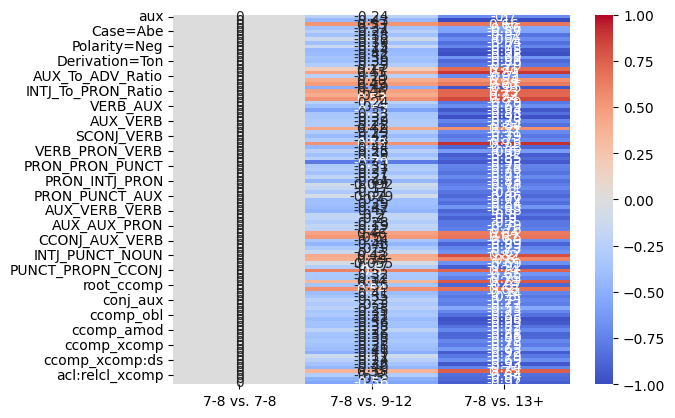

In [ ]:
sns.heatmap(testing_df_edited[sub_columns(ef_df.columns, '7')], cmap='coolwarm', vmin=-1, vmax=1, annot=True)

## Plot KFA results distributions and compare with different feature sets

In [ ]:
import matplotlib.pyplot as plt

def plotKFAValuesDistribution(effect_sizes_per_run, chosen_comp, weak_feat_indices, medium_feat_indices, strong_feat_indices):
    """
    Helper function for plotting histogram distribution of KFA results.
    Optionally you can add a subset of features (their indices from index_dict) to e.g. only include features with consitently strong effects.
    The red lines mark the area where effect sizes are not significant
    """

    f, axes = plt.subplots(1, 4, figsize=(10, 5), sharex=True)

    all_vals = []
    weak_vals = []
    medium_vals = []
    strong_vals = []
    for i in effect_sizes_per_run:
            weak_vals += [effect_sizes_per_run[i][chosen_comp][j] for j in weak_feat_indices]
            medium_vals += [effect_sizes_per_run[i][chosen_comp][j] for j in medium_feat_indices]
            strong_vals += [effect_sizes_per_run[i][chosen_comp][j] for j in strong_feat_indices]
            all_vals += effect_sizes_per_run[i][chosen_comp]
    sns.histplot(all_vals, ax=axes[0])
    axes[0].set_title('All features')
    sns.histplot(weak_vals, ax=axes[3])
    axes[1].set_title('Weak+ features')
    sns.histplot(medium_vals, ax=axes[2])
    axes[2].set_title('Medium+ features')
    sns.histplot(strong_vals, ax=axes[1])
    axes[3].set_title('Strong+ features')
    #plt.axvline(0.29, 0, 15000, color='r')
    #plt.axvline(-0.29, 0, 15000, color='r')

In [ ]:
cons_strong_indices = [feat_dict[feat] for feat in consistent_strong_feats]
cons_med_indices = [feat_dict[feat] for feat in consistent_medium_feats]
cons_weak_indices = [feat_dict[feat] for feat in consistent_weak_feats]

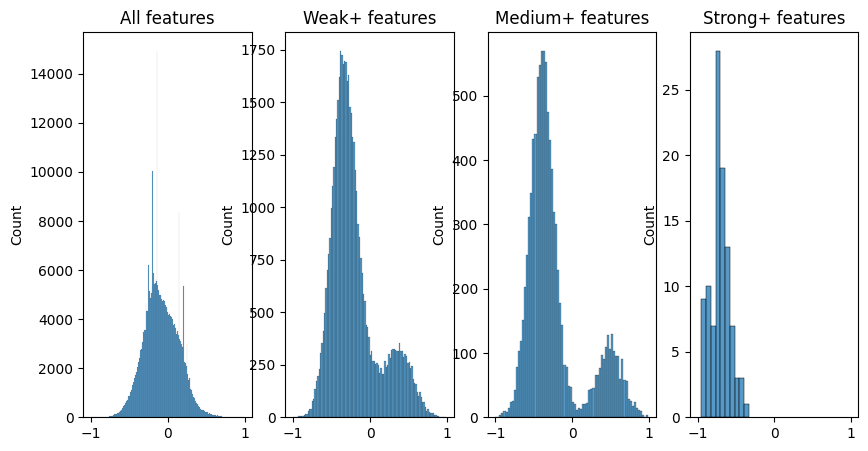

In [ ]:
# 7-8 vs. 9-12
plotKFAValuesDistribution(effect_sizes_per_run, '7-8 vs. 9-12', cons_strong_indices, cons_med_indices, cons_weak_indices)

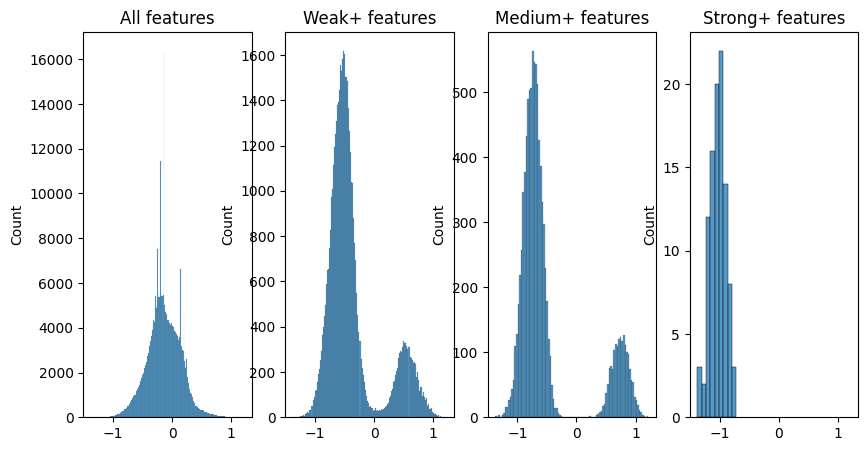

In [ ]:
plotKFAValuesDistribution(effect_sizes_per_run, '7-8 vs. 13+', cons_strong_indices, cons_med_indices, cons_weak_indices)

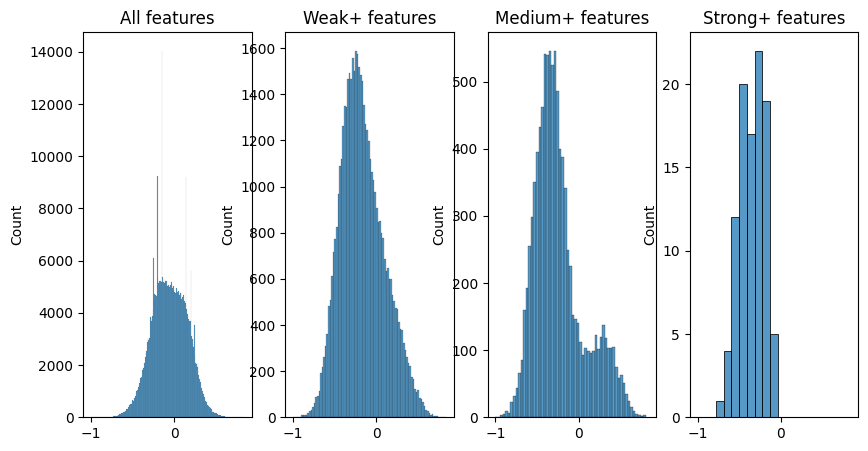

In [ ]:
# 9-12 vs. 13+
plotKFAValuesDistribution(effect_sizes_per_run, '9-12 vs. 13+', cons_strong_indices, cons_med_indices, cons_weak_indices)

## Additional look at differentiating features between 9-12 and 13+

In [ ]:
#Function for calculating which features are classified as somewhat meaningful for a set of cohen's d values
def meaningfulFeatsCustomized(meaningful_ef_size, ef_sizes):

    sep_between_two = []
    y_1 = abs(np.nan_to_num(ef_sizes['9-12 vs. 13+']))
    for i in index_dict:
        if y_1[i]>=meaningful_ef_size:
            sep_between_two.append(index_dict[i])

    return list(set(sep_between_two))

In [ ]:
m_f_s_c = []
m_f_m_c= []
m_f_w_c = []
with tqdm(range(RUNS), desc="Calculating meaningful effects per run...") as pbar:
    for i in effect_sizes_per_run:
        m_f_s_c.append(meaningfulFeatsCustomized(0.79, effect_sizes_per_run[i]))
        m_f_m_c.append(meaningfulFeatsCustomized(0.49, effect_sizes_per_run[i]))
        m_f_w_c.append(meaningfulFeatsCustomized(0.29, effect_sizes_per_run[i]))
        pbar.update(1)

Calculating meaningful effects per run...: 100%|██████████| 100/100 [00:00<00:00, 1067.65it/s]


In [ ]:
print("Strong ef size: ",Counter(list(itertools.chain.from_iterable(m_f_s_c))))
f_c_s = dict(Counter(list(itertools.chain.from_iterable(m_f_s_c))))
print("Medium ef size: ",Counter(list(itertools.chain.from_iterable(m_f_m_c))))
f_c_m = dict(Counter(list(itertools.chain.from_iterable(m_f_m_c))))
print("Weak ef size: ",Counter(list(itertools.chain.from_iterable(m_f_w_c))))
f_c_w = dict(Counter(list(itertools.chain.from_iterable(m_f_w_c))))

Strong ef size:  Counter({'PUNCT_VERB_ADJ': 18, 'AUX_PRON_PUNCT': 13, 'PUNCT_PRON_INTJ': 10, 'PRON_INTJ': 7, 'PRON_PUNCT_AUX': 4, 'PUNCT_AUX': 3, 'PUNCT_AUX_AUX': 3, 'ADP_AUX_PRON': 3, 'AUX_PRON_ADJ': 3, 'Reflex=Yes': 3, 'AUX_PROPN_ADP': 3, 'VERB_CCONJ_ADJ': 3, 'PUNCT_VERB_AUX': 2, 'Number[psor]=Sing': 2, 'Person[psor]=1': 2, 'PROPN_ADP_AUX': 2, 'ADP_ADV_SCONJ': 2, 'PUNCT_VERB': 2, 'VERB_AUX_PUNCT': 2, 'AUX_To_ADV_Ratio': 1, 'ADP_PRON_NOUN': 1, 'SCONJ_AUX_AUX': 1, 'PRON_Phrase': 1, 'VERB_PRON_CCONJ': 1, 'cop_aux': 1, 'PUNCT_AUX_VERB': 1, 'ADJ_PUNCT_AUX': 1, 'PRON_PUNCT': 1, 'AUX_PROPN_PRON': 1, 'PUNCT_VERB_PRON': 1, 'AUX_PRON_PROPN': 1, 'VERB_CCONJ_ADV': 1, 'AUX_AUX_ADJ': 1, 'csubj:cop_obj': 1, 'PUNCT_VERB_VERB': 1, 'PRON_PUNCT_ADP': 1, 'ADV_PUNCT_VERB': 1, 'ADP_PUNCT_VERB': 1, 'PRON_INTJ_NOUN': 1, 'PUNCT_NOUN_VERB': 1, 'PUNCT_VERB_NOUN': 1, 'AUX_PROPN_ADV': 1, 'PROPN_CCONJ_PROPN': 1, 'PROPN_To_AUX_Ratio': 1})
Medium ef size:  Counter({'PUNCT_PRON_INTJ': 93, 'PRON_INTJ': 87, 'AUX_PRON_

In [ ]:
#In how big a proportion do feats need to appear in to be considered consistant

CONSISTANT = 0.90

c_s_f = [feat for feat in f_c_s if f_c_s[feat]/RUNS > CONSISTANT]
c_m_f = [feat for feat in f_c_m if f_c_m[feat]/RUNS > CONSISTANT]
c_w_f = [feat for feat in f_c_w if f_c_w[feat]/RUNS > CONSISTANT]

In [ ]:
print("Consitently strong ef: ",c_s_f)
print("Consitently medium ef: ",c_m_f)
print("Consitently weak ef: ",c_w_f)

Consitently strong ef:  []
Consitently medium ef:  ['PUNCT_PRON_INTJ']
Consitently weak ef:  ['ADP_ADV_SCONJ', 'flat:name_aux', 'ADP_AUX_SCONJ', 'flat:name_obj', 'PUNCT_PRON_INTJ', 'PRON_PUNCT_AUX', 'AUX_PRON_ADJ', 'Number[psor]=Sing', 'PUNCT_VERB_ADJ', 'PROPN_AUX_NUM', 'AUX_AUX_PROPN', 'Person[psor]=1', 'AUX_ADJ_PUNCT', 'PRON_INTJ_PRON', 'ADP_PUNCT_VERB', 'ADP_AUX_PRON', 'PUNCT_AUX_AUX', 'PRON_INTJ', 'PUNCT_AUX', 'AUX_PRON_PUNCT', 'PRON_INTJ_PUNCT', 'VERB_CCONJ_ADJ', 'flat:name_flat:foreign']


In [ ]:
c_s_i = [feat_dict[feat] for feat in c_s_f]
c_m_i = [feat_dict[feat] for feat in c_m_f]
c_w_i = [feat_dict[feat] for feat in c_w_f]

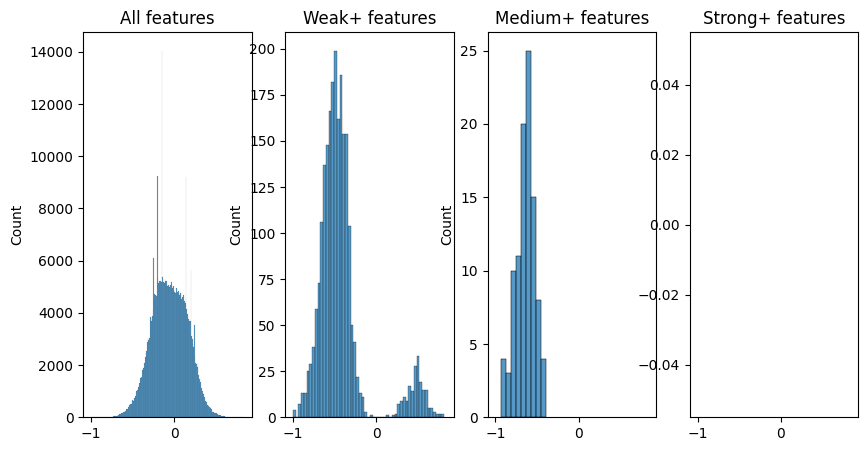

In [ ]:
plotKFAValuesDistribution(effect_sizes_per_run, '9-12 vs. 13+', c_s_i, c_m_i, c_w_i)

In [ ]:
testing_df_2 = ef_df.copy()
print(len(testing_df_2))
#remove = ['root']
# ,
#most_important = ['ccomp','vocative', 'nmod','nmod:gsubj','VerbForm=Part','Connegative=Yes', 'CCONJ', 'AUX','nummod','compound:nn', 'nsubj', 'Person=3', 'Case=Abe']
#most_important_2 = c_s_f
#most_important_2 = c_m_f
most_important_2 = c_w_f
to_drop_2 = [x for x in index_dict.values() if x not in most_important_2]
print(most_important_2)
testing_df_edited_2 = testing_df_2.drop(to_drop_2)
print(len(testing_df_edited_2))

4017
['ADP_ADV_SCONJ', 'flat:name_aux', 'ADP_AUX_SCONJ', 'flat:name_obj', 'PUNCT_PRON_INTJ', 'PRON_PUNCT_AUX', 'AUX_PRON_ADJ', 'Number[psor]=Sing', 'PUNCT_VERB_ADJ', 'PROPN_AUX_NUM', 'AUX_AUX_PROPN', 'Person[psor]=1', 'AUX_ADJ_PUNCT', 'PRON_INTJ_PRON', 'ADP_PUNCT_VERB', 'ADP_AUX_PRON', 'PUNCT_AUX_AUX', 'PRON_INTJ', 'PUNCT_AUX', 'AUX_PRON_PUNCT', 'PRON_INTJ_PUNCT', 'VERB_CCONJ_ADJ', 'flat:name_flat:foreign']
23


<Axes: >

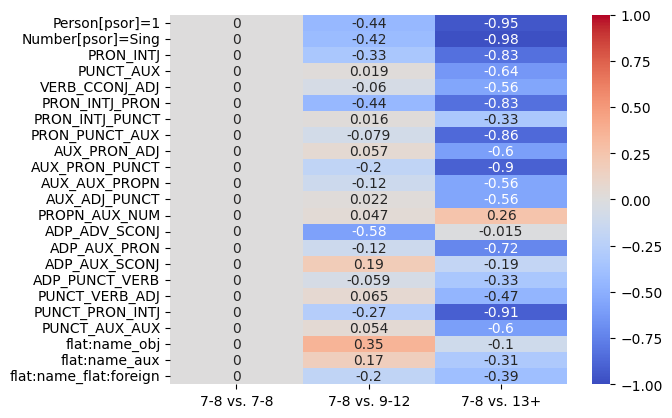

In [ ]:
sns.heatmap(testing_df_edited_2[sub_columns(ef_df.columns, '7')], cmap='coolwarm', vmin=-1, vmax=1, annot=True)

## Other tests

In [ ]:
def testTTR(corpus: dict):
    returnable = {}
    for id in corpus:
        df = corpus[id]
        types = len(df.drop_duplicates(['text'])['text'])
        tokens = len(df)
        returnable[id] = (types/tokens)
    return returnable


In [ ]:
new_func = testTTR(corpus)

In [ ]:
old_func = bdf.getTypeTokenRatios(bdf.getWordFrequencies(corpus), bdf.getTokenAmounts(corpus))

In [ ]:
young = []
mid = []
old = []
for id in new_func:
    if old_func[id] != new_func[id]:
        print("Different!")
        print(id)
        print(old_func[id])
        print(new_func[id])

Different!
9789511269830_7_3
0.3797716370515506
0.3798392000540504
Different!
9789510487570_9_1
0.18924734464656331
0.18926260529849837
Different!
9789526308623_14_3
0.23398835516739447
0.23404900533721495
Different!
9789520454371_9_2
0.4034324241495556
0.4034630707937481


In [ ]:
windows = ['7','9','1']
def sub_columns_expanded(columns: list[str], start: str) -> list[str]:
    return [c for c in columns if c[0:len(start)] == start]

In [ ]:
temp_1_df = testing_df_edited.copy()
prep_for_cossim = {}
for window in windows:
    prep_for_cossim[window] = temp_1_df[sub_columns(temp_1_df.columns, window)].to_numpy(na_value=0.0)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
sim_scores = {}
for key1 in prep_for_cossim:
    scores = []
    for key2 in prep_for_cossim:
        scores.append(cosine_similarity(prep_for_cossim[key1], prep_for_cossim[key2]))
    sim_scores[key1] = scores

In [ ]:
#Create df
matrix_df = pd.DataFrame.from_dict(sim_scores, orient='index').transpose()
#Set indexes correctly
matrix_df.index = prep_for_cossim.keys()
#Dig out the values from nd.array
matrix_df_2 = matrix_df.copy().applymap(lambda x: x[0][0])

<Axes: >

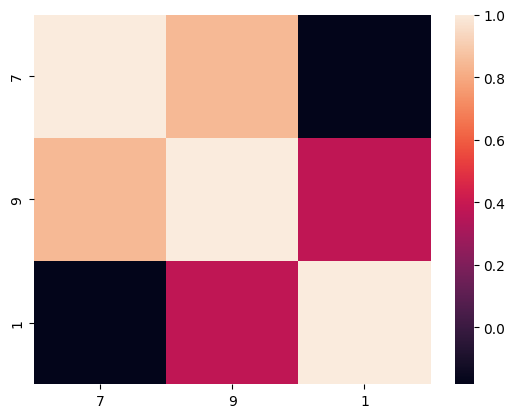

In [ ]:
sns.heatmap(matrix_df_2)